## User settings

## Query

In [1]:
from badassdatascience.forex.database.mongodb.pull_forex_data_from_database.pull_forex_data_from_database import query_single_instrument_and_single_granularity 

In [2]:
df = query_single_instrument_and_single_granularity(pull_from_database = False)

In [3]:
df.tail(2)

,_id,volume,time,instrument,granularity,time_iso,weekday,hour,bid_o,bid_h,...,ask_c,ask_return,ask_volatility,mid_o,mid_h,mid_l,mid_c,mid_return,mid_volatility,time_iso_pd_datetime
384457,68184250a57b2b64dce17105,946,1746419400,EUR/USD,M15,2025-05-05T00:30:00-04:00,0,0,1.13360,1.13365,...,1.13350,-0.00026,0.00086,1.13368,1.13374,1.13287,1.13342,-0.00026,0.00087,2025-05-05 00:30:00-04:00
384458,681845d47ea011061b4d30b0,960,1746420300,EUR/USD,M15,2025-05-05T00:45:00-04:00,0,0,1.13335,1.13382,...,1.13382,0.00031,0.00055,1.13343,1.13390,1.13336,1.13374,0.00031,0.00054,2025-05-05 00:45:00-04:00


## Find all timestamps, stepped by granularity, for the full timestamp range

In [4]:
from badassdatascience.forex.utilities.granularities import get_df_merged_by_seconds_interval

In [5]:
df_full_even_timestamps = get_df_merged_by_seconds_interval(df)

In [6]:
df_full_even_timestamps.tail(2)

,time,_id,volume,instrument,granularity,time_iso,weekday,hour,bid_o,bid_h,...,ask_c,ask_return,ask_volatility,mid_o,mid_h,mid_l,mid_c,mid_return,mid_volatility,time_iso_pd_datetime
537643,1746419400,68184250a57b2b64dce17105,946.0,EUR/USD,M15,2025-05-05T00:30:00-04:00,0.0,0.0,1.13360,1.13365,...,1.13350,-0.00026,0.00086,1.13368,1.13374,1.13287,1.13342,-0.00026,0.00087,2025-05-05 00:30:00-04:00
537644,1746420300,681845d47ea011061b4d30b0,960.0,EUR/USD,M15,2025-05-05T00:45:00-04:00,0.0,0.0,1.13335,1.13382,...,1.13382,0.00031,0.00055,1.13343,1.13390,1.13336,1.13374,0.00031,0.00054,2025-05-05 00:45:00-04:00


## Get a df with no nulls and no intention of forward-filling

In [7]:
df_NO_ff = df.dropna().copy()

In [8]:
print(len(df_NO_ff.index) == len(df.index))

True


In [9]:
print(len(df_NO_ff), len(df.index), len(df_full_even_timestamps))

384459 384459 537645


## Forward-fill

In [10]:
from badassdatascience.forex.utilities.forward_fill import ff
from badassdatascience.forex.utilities.forward_fill import ff_test_plots

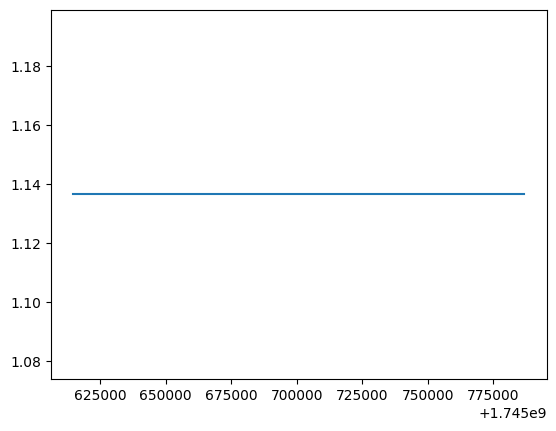

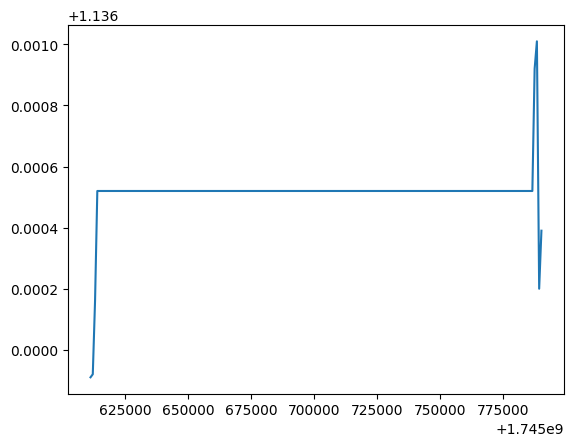

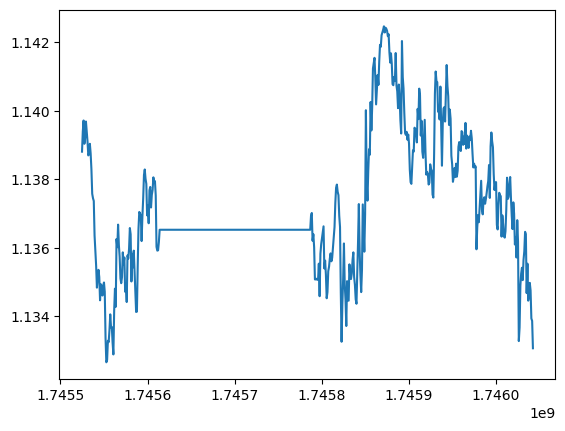

In [11]:
df_post_ff = ff(df_full_even_timestamps)
ff_test_plots(df_post_ff)

## TA-Lib

In [12]:
import pandas as pd
import talib

In [13]:
def test_for_all_null(df, column_name):
    return df[column_name].isna().value_counts().get(True) == len(df[column_name])

def do_ta_calculations(df, column_name = 'mid_c', time_column_name = 'time'):
    x = df[column_name].values
    result_dict = {}
    result_len_list = []
    
    for item in dir(talib):
        if item.isupper() and item[0:2] != '__':

            try:
                # this gets the single-argument stuff
                result = eval('talib.' + item + '(x)')
            except:
                continue

            item_edited = item
            
            if str(type(result)) == "<class 'numpy.ndarray'>":
                result_dict[item_edited] = result
                result_len_list.append(len(result))
            
            elif str(type(result)) == "<class 'tuple'>":
                for i, array in enumerate(result):
                    item_edited = item + '_element_' + str(i)
                    result_dict[item_edited] = array
                    result_len_list.append(len(array))

            else:
                print()
                print('Something else found...')
                print(type(result))
                print()
                break
    
    df_new = pd.DataFrame(result_dict)

    column_list = df_new.columns
    columns_to_drop = []
    for col in column_list:
        if test_for_all_null(df_new, col):
            columns_to_drop.append(col)
    if len(columns_to_drop) > 0:
        df_new = df_new.drop(columns = columns_to_drop)

    df_new[time_column_name] = df[time_column_name]
    df_new[column_name] = df[column_name]
    df_new['instrument'] = df['instrument']
    df_new['granularity'] = df['granularity']

    final_column_list = [time_column_name, column_name, 'instrument', 'granularity']
    final_column_list.extend(column_list)

    return df_new[final_column_list], column_list

In [14]:
df_full_ff_timestep_results, ta_full_ff_results_column_list = do_ta_calculations(df_post_ff)
df_NO_ff_timestep_results, ta_NO_ff_results_column_list = do_ta_calculations(df_NO_ff)

In [15]:
df_full_ff_timestep_results.head(3)

,time,mid_c,instrument,granularity,ACOS,APO,ASIN,ATAN,AVGDEV,BBANDS_element_0,...,SUM,T3,TAN,TANH,TEMA,TRIMA,TRIX,TSF,VAR,WMA
0,1262540700,1.43172,EUR/USD,M15,NaN,NaN,NaN,0.961104,NaN,NaN,...,NaN,NaN,7.143878,0.892019,NaN,NaN,NaN,NaN,NaN,NaN
1,1262541600,1.43110,EUR/USD,M15,NaN,NaN,NaN,0.960901,NaN,NaN,...,NaN,NaN,7.111758,0.891892,NaN,NaN,NaN,NaN,NaN,NaN
2,1262542500,1.43155,EUR/USD,M15,NaN,NaN,NaN,0.961049,NaN,NaN,...,NaN,NaN,7.135042,0.891984,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
ta_full_ff_results_column_list[0:10]

Index(['ACOS', 'APO', 'ASIN', 'ATAN', 'AVGDEV', 'BBANDS_element_0',
       'BBANDS_element_1', 'BBANDS_element_2', 'CEIL', 'CMO'],
      dtype='object')

In [17]:
df_NO_ff_timestep_results.head(3)

,time,mid_c,instrument,granularity,ACOS,APO,ASIN,ATAN,AVGDEV,BBANDS_element_0,...,SUM,T3,TAN,TANH,TEMA,TRIMA,TRIX,TSF,VAR,WMA
0,1262540700,1.43172,EUR/USD,M15,NaN,NaN,NaN,0.961104,NaN,NaN,...,NaN,NaN,7.143878,0.892019,NaN,NaN,NaN,NaN,NaN,NaN
1,1262541600,1.43110,EUR/USD,M15,NaN,NaN,NaN,0.960901,NaN,NaN,...,NaN,NaN,7.111758,0.891892,NaN,NaN,NaN,NaN,NaN,NaN
2,1262542500,1.43155,EUR/USD,M15,NaN,NaN,NaN,0.961049,NaN,NaN,...,NaN,NaN,7.135042,0.891984,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
ta_NO_ff_results_column_list[0:10]

Index(['ACOS', 'APO', 'ASIN', 'ATAN', 'AVGDEV', 'BBANDS_element_0',
       'BBANDS_element_1', 'BBANDS_element_2', 'CEIL', 'CMO'],
      dtype='object')

## Transpose

In [19]:
from badassdatascience.forex.utilities.transpose import transpose_it

In [20]:
df_full_ff_timestamp_transposed = transpose_it(df_full_ff_timestep_results, ta_full_ff_results_column_list)

In [21]:
df_full_ff_timestamp_transposed

,index,combined,mid_c
4,ACOS,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
5,APO,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
6,ASIN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
7,ATAN,"[0.9611042689293725, 0.9609009192040567, 0.961...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
8,AVGDEV,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
...,...,...,...
75,TRIMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
76,TRIX,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
77,TSF,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
78,VAR,"[nan, nan, nan, nan, 7.187999928603972e-08, 1....","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."


In [22]:
df_NO_ff_timestamp_transposed = transpose_it(df_NO_ff_timestep_results, ta_NO_ff_results_column_list)

In [23]:
df_NO_ff_timestamp_transposed

,index,combined,mid_c
4,ACOS,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
5,APO,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
6,ASIN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
7,ATAN,"[0.9611042689293725, 0.9609009192040567, 0.961...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
8,AVGDEV,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
...,...,...,...
75,TRIMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
76,TRIX,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
77,TSF,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."
78,VAR,"[nan, nan, nan, nan, 7.187999928603972e-08, 1....","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1..."


## Tag and stack the two dataframes

In [24]:
import pandas as pd

In [25]:
df_full_ff_timestamp_transposed['group'] = 'full_ff_timestep'
df_NO_ff_timestamp_transposed['group'] = 'no_ff_timestep'
df_all = pd.concat([df_full_ff_timestamp_transposed, df_NO_ff_timestamp_transposed])

In [26]:
df_all

,index,combined,mid_c,group
4,ACOS,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",full_ff_timestep
5,APO,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",full_ff_timestep
6,ASIN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",full_ff_timestep
7,ATAN,"[0.9611042689293725, 0.9609009192040567, 0.961...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",full_ff_timestep
8,AVGDEV,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",full_ff_timestep
...,...,...,...,...
75,TRIMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",no_ff_timestep
76,TRIX,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",no_ff_timestep
77,TSF,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",no_ff_timestep
78,VAR,"[nan, nan, nan, nan, 7.187999928603972e-08, 1....","[1.43172, 1.4311, 1.43155, 1.43106, 1.43157, 1...",no_ff_timestep


## Get sparky

In [28]:
import pyspark
import pyspark.sql.functions as f
from pyspark.sql.types import FloatType

from badassdatascience.utilities.badass_spark.spark_session import get_spark_session

In [29]:
config = {
    'spark_config' : [
        ('spark.executor.memory', '100g'),
        ('spark.executor.cores', '20'),
        ('spark.cores.max', '20'),
        ('spark.driver.memory', '100g'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
    ]
}

spark = get_spark_session(config['spark_config'])

25/05/06 20:06:27 WARN Utils: Your hostname, emily-MS-7B96 resolves to a loopback address: 127.0.1.1; using 192.168.1.231 instead (on interface wlp5s0)
25/05/06 20:06:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 20:06:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
sdf = spark.createDataFrame(df_all)
sdf.show(2)

25/05/06 20:06:55 WARN TaskSetManager: Stage 0 contains a task of very large size (1103566 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+----------------+
|index|            combined|               mid_c|           group|
+-----+--------------------+--------------------+----------------+
| ACOS|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|
|  APO|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|
+-----+--------------------+--------------------+----------------+
only showing top 2 rows



In [31]:
lag_max = 200  # set somewhere else
y_column_name = 'mid_c'  # set somewhere else
granger_causality_test_to_use = 'ssr_chi2test'  # set somewhere else

In [32]:
pdf_lags = pd.DataFrame({'lag' : range(1, lag_max + 1)})
sdf_lags = spark.createDataFrame(pdf_lags)
sdf_all_with_lags = sdf.crossJoin(sdf_lags).coalesce(15)

In [33]:
sdf_all_with_lags.show(4)

25/05/06 20:07:00 WARN TaskSetManager: Stage 2 contains a task of very large size (1103567 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+----------------+---+
|index|            combined|               mid_c|           group|lag|
+-----+--------------------+--------------------+----------------+---+
| ACOS|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|  1|
| ACOS|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|  2|
| ACOS|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|  3|
| ACOS|[NULL, NULL, NULL...|[1.43172, 1.4311,...|full_ff_timestep|  4|
+-----+--------------------+--------------------+----------------+---+
only showing top 4 rows



In [34]:
def gc_it(caused_by, causing, only_one_lag, test_name):
    import pandas as pd
    from statsmodels.tsa.stattools import grangercausalitytests

    import warnings
    warnings.filterwarnings('ignore')
    
    df = pd.DataFrame({'caused_by' : caused_by, 'causing' : causing}).dropna()
    M = df.to_numpy()

    test_result = grangercausalitytests(M, maxlag = [only_one_lag], verbose = False)
    p_value = test_result[only_one_lag][0][test_name][1]

    return float(p_value)

udf_gc_it = f.udf(gc_it, FloatType())

In [35]:
sdf_granger_causality_test_p_computed = (
    sdf_all_with_lags
    .withColumn('test_name', f.lit(granger_causality_test_to_use))
    .withColumn(
        'p_value',
        udf_gc_it(f.col(y_column_name), f.col('combined'), f.col('lag'), f.col('test_name'))
    )
    .drop('combined', y_column_name, 'test_name')
    .withColumn('minus_log_10_p_value', -1. * f.log10(f.col('p_value')))
)               

In [36]:
sdf_granger_causality_test_p_computed.show(10)

25/05/06 20:07:07 WARN TaskSetManager: Stage 4 contains a task of very large size (1103567 KiB). The maximum recommended task size is 1000 KiB.


+-----+----------------+---+-----------+--------------------+
|index|           group|lag|    p_value|minus_log_10_p_value|
+-----+----------------+---+-----------+--------------------+
| ACOS|full_ff_timestep|  1|0.011923095|  1.9236109879908876|
| ACOS|full_ff_timestep|  2|0.009127604|  2.0396432174265695|
| ACOS|full_ff_timestep|  3|0.010455513|   1.980654638160048|
| ACOS|full_ff_timestep|  4|  0.0205097|   1.688040705670221|
| ACOS|full_ff_timestep|  5|0.020270672|  1.6931318601474805|
| ACOS|full_ff_timestep|  6|0.011597349|  1.9356412618307162|
| ACOS|full_ff_timestep|  7|0.021099797|  1.6757217329126897|
| ACOS|full_ff_timestep|  8|0.040829346|  1.3890275809286299|
| ACOS|full_ff_timestep|  9|0.002655837|   2.575798585211114|
| ACOS|full_ff_timestep| 10|0.004200898|  2.3766578517695636|
+-----+----------------+---+-----------+--------------------+
only showing top 10 rows



In [37]:
sdf_pivot_full_ff_timestep = (
    sdf_granger_causality_test_p_computed
    .select('index', 'group', 'lag', 'minus_log_10_p_value')
    .where(f.col('group') == 'full_ff_timestep')
    .where((f.col('index') == 'ACOS') | (f.col('index') == 'ATAN'))
    .drop('group')
    .groupBy('index')
    .pivot('lag')
    .max('minus_log_10_p_value')
    .coalesce(15)
)

25/05/06 20:07:22 WARN TaskSetManager: Stage 6 contains a task of very large size (1103567 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
sdf_pivot_full_ff_timestep.show(3)

25/05/06 20:07:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/06 20:07:25 WARN TaskSetManager: Stage 15 contains a task of very large size (1103567 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
#full_ff_timestep
#no_ff_timestep